# Importing required libraries

In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns, ipywidgets as widgets
import random,uuid,io,joblib

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import *
from skimage.feature import hog
from PIL import Image
from skimage.color import rgb2gray
from IPython.display import display,HTML # Used for displaying widgets or output directly in the cell

# Acquiring the dataset and manupulating it for computational efficiency

In [53]:
resize=(128,128) # Ensures that every image is reduced to 64*64=4096 feature vactors
dataset= "DataSet" # Folder name of dataset and here both dataset and py file are at same location
classification_rule={'Cats':0,'Dogs':1} # Classification rule of the images

In [54]:
# Function for extracting the HOG feature
#=============================================
def extract_hog_features(image):
    image_resize=image.resize(resize)
    gray_image=image_resize.convert('L')
    features,_=hog(gray_image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm="L2-Hys", visualize=True)
    return features

In [55]:
# Function of loading all the images as a vector
#========================================================
def load_images(dataset):
    global original_image_object
    data,labels,original_image_object=[],[],[]
    for category in classification_rule:
        target_folder=os.path.join(dataset, category)
        images=os.listdir(target_folder)
        for image in images:
             try:
                image_object=Image.open(os.path.join(target_folder,image))
                original_image_object.append(image_object)
                features=extract_hog_features(image_object)
                flattened_image=features.flatten()
                data.append(flattened_image)
                labels.append(classification_rule[category])
             except :
                print(f"Error : Unable to load the Image : {image} belonging to the category : {category}!")
                continue
    return np.array(data), np.array(labels)

# Main Pipeline

In [56]:
def main():
    print("Loading the dataset")
    feature_vectors,labels=load_images(dataset)

    print("Normalizing all the feature vectors")
    global normalized_feature_vectors
    scaler_object=StandardScaler()
    normalized_feature_vectors=scaler_object.fit_transform(feature_vectors)

    print("Splitting the dataset")
    global X_train,Y_train,X_test,Y_test,Image_test,Image_train
    X_train,X_test,Y_train,Y_test,Image_train,Image_test=train_test_split(normalized_feature_vectors,labels,original_image_object
                                                                          , random_state=42, test_size=0.2)
    
    print("Training our SVM model")
    global model
    model=SVC(kernel='rbf',C=10 )
    model.fit(X_train,Y_train)

    joblib.dump(model,'model.pkl')
    joblib.dump(scaler_object,'scaler_object.pkl')
    
    print("Evaluating the model")
    global Y_predicted
    Y_predicted=model.predict(X_test)
    print("*"*80)
    print(f"The accuracy percentage is : {accuracy_score(Y_predicted,Y_test)*100}")
    print("*"*80)
    print(f"The classification report\n{classification_report(Y_predicted,Y_test,target_names=classification_rule.keys())}")
    print("*"*80)

# Visualizations and Plots

In [57]:
def accuracy_bar_plot(accuracy):
    plt.figure(figsize=(4,4))
    sns.barplot(x=["Model_Accuracy"], y=accuracy)
    plt.title("Model_Accuracy_Bar_Plot\n",fontsize=15)
    plt.ylabel("Accuracy_In_Percentage")
    plt.ylim(0,100)
    plt.grid(axis='y',linestyle='--',alpha=0.6)
    plt.axhline(accuracy, color='k', linestyle='--', linewidth=1)
    plt.text(0,accuracy+1,f"{accuracy}",fontsize=18,ha='center',color='purple')
    plt.show()    

In [58]:
def confusion_matrix_heatmap(Y_test,Y_predicted,class_names,class_labels):
    conf_matrix=confusion_matrix(Y_test,Y_predicted,labels=[0,1])
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix,annot=True,fmt='d',xticklabels=classification_rule.keys(),yticklabels=classification_rule.keys())
    plt.title("Confusion_Matrix_Heatmap")
    plt.tight_layout()
    plt.show()

In [59]:
def random_sampling(X_test,Y_test,Y_predicted):
    indices=[i for i in range(len(Y_predicted))]
    sampling_indices=random.sample(indices,min(9,len(indices)))
    fig,axes=plt.subplots(3,3, figsize=(12,8))
    axes=axes.flatten()
    for i,j in enumerate(sampling_indices):
        axes[i].imshow(Image_test[j])
        axes[i].set_title(f"Predicted : {'Cat' if Y_predicted[j]==0 else 'Dog'} but we have : {'Cat' if Y_test[j]==0 else 'Dog'}")
        axes[i].axis('off')  
    plt.suptitle("Random_Sampling & Its_prediction_crosscheck\n", fontsize=16)
    for k in range(min(9,len(indices)),9):
        fig.delaxes(axes[k])
    plt.tight_layout() 
    plt.show()

In [60]:
def misclassified_sampling():
    indices=[i for i in range(len(Y_predicted)) if Y_predicted[i]!=Y_test[i]]
    required_samples_images=random.sample(indices,min(9,len(indices)))
    fig,axes=plt.subplots(3,3, figsize=(12,8))
    axes=axes.flatten()
    for i,j in enumerate(required_samples_images):
        axes[i].imshow(Image_test[j])
        axes[i].set_title(f"Predicted : {'Cat' if Y_predicted[j]==0 else 'Dog'} but we have : {'Cat' if Y_test[j]==0 else 'Dog'}")
        axes[i].axis('off')  
    plt.suptitle("Misclassified_Prediction\n", fontsize=16)
    for k in range(min(9,len(indices)),9):
        fig.delaxes(axes[k])
    plt.tight_layout() 
    plt.show()

# Running the code

In [61]:
if __name__ == "__main__":
    main()

Loading the dataset
Normalizing all the feature vectors
Splitting the dataset
Training our SVM model
Evaluating the model
********************************************************************************
The accuracy percentage is : 85.0
********************************************************************************
The classification report
              precision    recall  f1-score   support

        Cats       0.90      0.83      0.86        23
        Dogs       0.79      0.88      0.83        17

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40

********************************************************************************


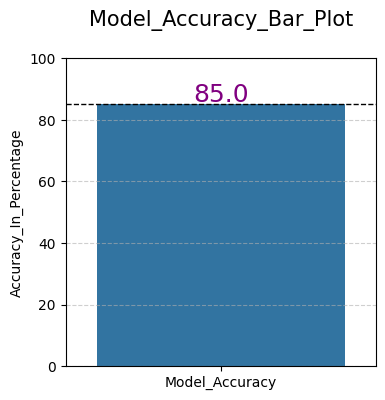

In [62]:
accuracy_bar_plot(accuracy_score(Y_predicted,Y_test)*100)

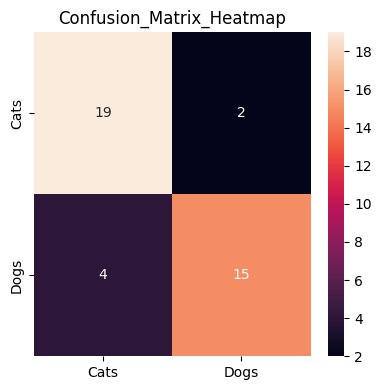

In [63]:
confusion_matrix_heatmap(Y_test,Y_predicted,['Cats','Dogs'],[0,1])

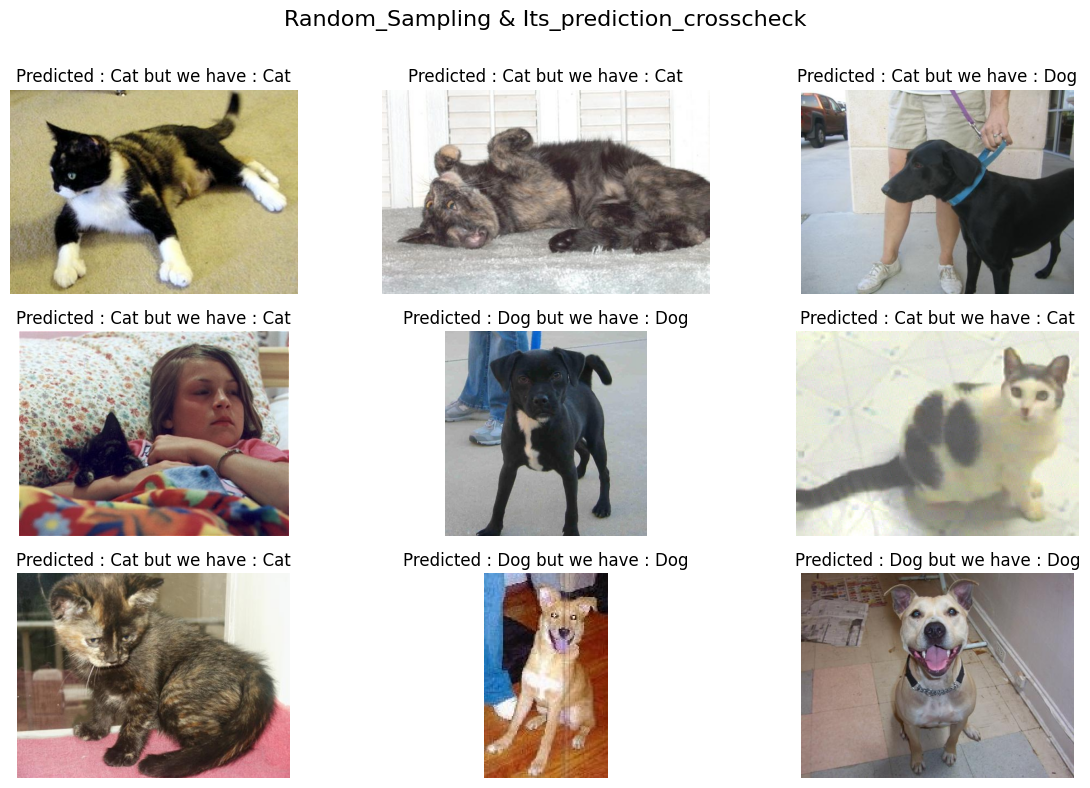

In [64]:
random_sampling(X_test,Y_test,Y_predicted)

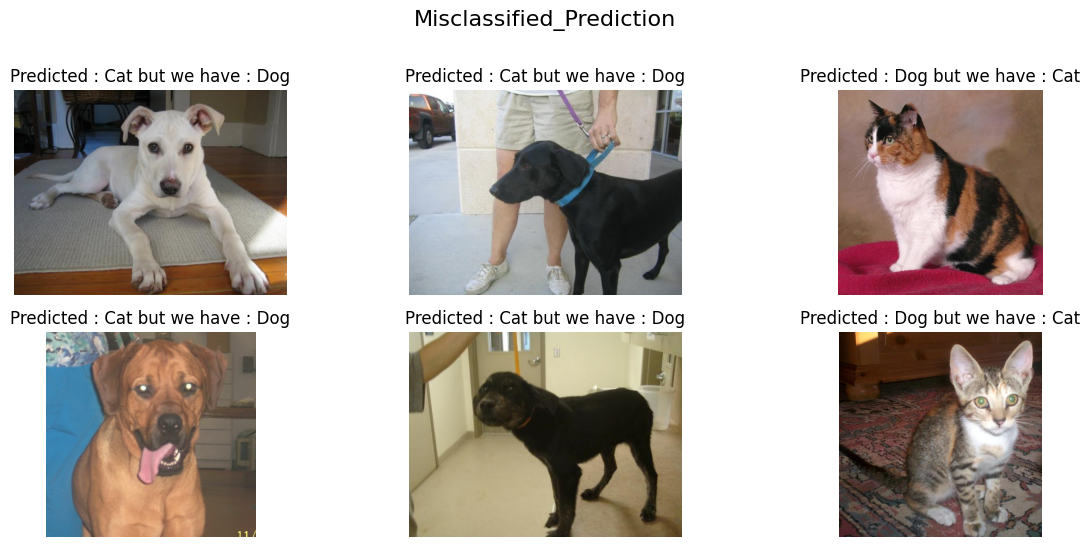

In [65]:
misclassified_sampling()

# Defining the predictive model interface

In [96]:
# Loading the  model and scaler objected which are already dumped
#===================================================================
model = joblib.load('model.pkl')
scaler = joblib.load('scaler_object.pkl')

# Uploader and output widget creation
#=======================================
uploader = widgets.FileUpload(accept='image/*', multiple=False)
output = widgets.Output() # Creates a certain area in the Outpult cell of the notebook
display(HTML(f"<h2 style='color: #4A90E2;'>Welcome to Our Cat & Dog Prediction Model \n{'='*35}</h2>"))
        
# Classification function defined
#==================================
def classify_image(change):
    output.clear_output()
    with output:
        try:
            # Check for uploaded content through uploader
            #=================================================
            if not uploader.value: # .value is a dictionary that holds the uploaded file(s)
                print("No file uploaded.")
                return

            uploaded_file = (
                list(uploader.value.values())[0]
                if isinstance(uploader.value, dict)
                else uploader.value[0]
            ) # Gives a dictionary of all attributes of the image
            image_data = uploaded_file['content']

            # Convert to image equlvalent binary format
            #=============================================
            image = Image.open(io.BytesIO(image_data)).convert("RGB")
            image = image.resize((128,128))
            image_array = np.array(image) / 255.0

            # Extract and scale features of the image_array
            #===================================================
            hog_features = extract_hog_features(image_array).flatten()
            scaled_features = scaler.transform([hog_features])

            # Prediction
            #===============
            prediction = model.predict(scaled_features)[0]
            label = "Cat" if prediction == 0 else "Dog"

            # Show image + prediction
            #============================
            plt.figure(figsize=(4, 4))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"The predicted class is : {label}", fontsize=14)
            plt.show()

        except Exception as e:
            print(f"Error: {e}")

uploader.observe(classify_image, names='value')
display(widgets.VBox([uploader, output])) # It places the uploader widget above the output area like this: